# Relationships Between Performance, Training Load, and Wellness

Our exploratory notebooks for performance, training load, and wellness have lead us to measures to quantify these 3 elements of each player. We have a summary measure for wellness and we can also explore the effect of its elements on performance. We also have a measure for a player's performance in max speed over 1 second achieved in a game. In terms of load, we have shown that we can quantify it in terms of training load, or RPE depending on the context. With these measures in mind, we can now explore the relationships between these 3 elements.

## Data Cleaning

On some of the game dates, we don't have RPE data. But, we are mainly concerned with the acute/chronic ratio which we can compute for the dates for which it is missing.

In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings

In [2]:
np.random.seed(5151)
warnings.filterwarnings('ignore')
raw_rpe_df = pd.read_csv('./processed_data/processed_rpe.csv')
raw_rpe = raw_rpe_df.copy()[['Date', 'PlayerID', 'RPE']]
print(raw_rpe_df.head())


   Unnamed: 0        Date  PlayerID  Training SessionType  Duration  RPE  \
0           0  2017-08-01        15         1    Strength      60.0  4.0   
1           1  2017-08-01         1         1       Speed      60.0  3.0   
2           2  2017-08-01         1         1    Strength      90.0  4.0   
3           3  2017-08-01         3         1       Speed      45.0  5.0   
4           4  2017-08-01         3         1    Strength      90.0  5.0   

   SessionLoad  DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
0        240.0      300.0               4.29              6.0          7.0   
1        180.0      540.0               4.29              0.0          0.0   
2        360.0      540.0               4.29              0.0          0.0   
3        225.0      675.0               4.29              7.0          7.0   
4        450.0      675.0               4.29              7.0          7.0   

   BestOutOfMyself  AcuteLoad  ChronicLoad  
0              2.0      42.86

### Drop Duplicate Dates

This occurs when there are multiple training sessions on the same date. We only care about the daily load so we can drop the duplicate sessions.

In [3]:
rpe_df = raw_rpe_df.copy()[['Date', 'PlayerID', 'DailyLoad', 'AcuteChronicRatio', 'AcuteLoad', 'ChronicLoad']]
subjective_performance_df = raw_rpe_df.copy()[['Date', 'PlayerID', 'ObjectiveRating', 'FocusRating', 'BestOutOfMyself']]
rpe_df.head()

,Date,PlayerID,DailyLoad,AcuteChronicRatio,AcuteLoad,ChronicLoad
0,2017-08-01,15,300.0,4.29,42.86,10.0
1,2017-08-01,1,540.0,4.29,77.14,18.0
2,2017-08-01,1,540.0,4.29,77.14,18.0
3,2017-08-01,3,675.0,4.29,96.43,22.5
4,2017-08-01,3,675.0,4.29,96.43,22.5


In [4]:
subjective_performance_df.head()

,Date,PlayerID,ObjectiveRating,FocusRating,BestOutOfMyself
0,2017-08-01,15,6.0,7.0,2.0
1,2017-08-01,1,0.0,0.0,2.0
2,2017-08-01,1,0.0,0.0,2.0
3,2017-08-01,3,7.0,7.0,2.0
4,2017-08-01,3,7.0,7.0,2.0


In [5]:
rpe_df = rpe_df.drop_duplicates()

In [6]:
rpe_df.head()

,Date,PlayerID,DailyLoad,AcuteChronicRatio,AcuteLoad,ChronicLoad
0,2017-08-01,15,300.0,4.29,42.86,10.0
1,2017-08-01,1,540.0,4.29,77.14,18.0
3,2017-08-01,3,675.0,4.29,96.43,22.5
5,2017-08-01,5,330.0,4.29,47.14,11.0
7,2017-08-01,8,345.0,4.29,49.29,11.5


### Fill In Missing RPE Data

This row should not be in the dataset since it is the first entry for this player and they are not training.

In [7]:
rpe_df = rpe_df[~ rpe_df['AcuteChronicRatio'].isnull()]

In [8]:
rpe_df['Date'] = pd.to_datetime(rpe_df['Date'])

Adding missing dates and player ids to rpe data:

In [9]:
dates = pd.date_range(start=min(rpe_df['Date']), end=max(rpe_df['Date']))
players = rpe_df['PlayerID'].unique()
idx = pd.MultiIndex.from_product((dates, players), names=['Date', 'PlayerID'])

rpe_df = rpe_df.set_index(['Date', 'PlayerID']).reindex(idx, fill_value=0).reset_index().sort_values(by=['Date', 'PlayerID'])



Use a rolling window to compute acute load and chronic load as it is incorrect in some cases:

In [10]:
temp = rpe_df[['Date','PlayerID','DailyLoad']].drop_duplicates()
past7Days = temp.groupby('PlayerID').rolling('7d', on='Date')['DailyLoad'].sum().reset_index()
past7Days['newAcuteLoad'] = (past7Days['DailyLoad'] / 7.).round(2)
past7Days = past7Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past7Days, how='left', on=['Date', 'PlayerID'])

In [11]:
past30Days = temp.groupby('PlayerID').rolling('30d', on='Date')['DailyLoad'].sum().reset_index()
past30Days['newChronicLoad'] = (past30Days['DailyLoad'] / 30.).round(2)
past30Days = past30Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past30Days, how="left", on=["Date", "PlayerID"])

In [12]:
rpe_df.drop(['ChronicLoad','AcuteLoad'],axis = 1, inplace = True)
rpe_df.rename(columns = {'newChronicLoad':'ChronicLoad','newAcuteLoad':'AcuteLoad'}, inplace = True)
rpe_df['AcuteChronicRatio'] = (rpe_df['AcuteLoad'] / rpe_df['ChronicLoad']).round(2)

In [13]:
gps_df = pd.read_csv('./processed_data/processed_gps.csv')
gps_df = gps_df.drop(columns=['Unnamed: 0'])
gps_df.head()


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame
0,2017-11-30,1,W,19,2,7.284728,4.423615
1,2017-11-30,1,W,19,3,6.852436,4.888893
2,2017-11-30,1,W,19,4,7.267784,5.694449
3,2017-11-30,1,W,19,6,6.338894,4.777782
4,2017-11-30,1,W,19,7,7.065283,4.091273


In [14]:
gps_df['Date'] = pd.to_datetime(gps_df['Date'])
train_performance = gps_df.merge(rpe_df[[
    'Date','PlayerID', 'AcuteLoad',
    'ChronicLoad','AcuteChronicRatio']],
    how='left', on= ['Date','PlayerID']).drop_duplicates()
print(len(train_performance))
train_performance.head()

443


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame,AcuteLoad,ChronicLoad,AcuteChronicRatio
0,2017-11-30,1,W,19,2,7.284728,4.423615,206.57,371.20,0.56
1,2017-11-30,1,W,19,3,6.852436,4.888893,407.86,454.67,0.90
2,2017-11-30,1,W,19,4,7.267784,5.694449,236.00,406.90,0.58
3,2017-11-30,1,W,19,6,6.338894,4.777782,297.29,415.87,0.71
4,2017-11-30,1,W,19,7,7.065283,4.091273,237.57,476.60,0.50


In [15]:
wellness_df = pd.read_csv('./processed_data/processed_wellness.csv')
wellness_df = wellness_df.drop(columns=['Unnamed: 0'])
wellness_df['Date'] = pd.to_datetime(wellness_df['Date'])
wellness_df.head()

,Date,PlayerID,MonitoringScore,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Menstruation,...,Nutrition,TrainingReadiness,StandardizedMonitoringScore,StandardizedPain,StandardizedIllness,StandardizedNutrition,StandardizedMenstruation,StandardizedTrainingReadiness,wellness,WellnessAffectedByLoad
0,2018-07-21,1,13,3,3,2,3,8.00,2,0,...,3,0,-1.448934,0.363863,0.330081,0.716267,0.716267,-2.456667,-0.038724,-2.495390
1,2018-07-21,2,19,4,3,4,4,8.00,4,0,...,3,0,0.170479,-2.748287,0.330081,0.716267,0.716267,-2.456667,-1.531461,-3.988127
2,2018-07-21,3,19,3,3,5,4,8.00,4,1,...,3,100,0.170479,0.363863,0.330081,0.716267,0.716267,0.407056,1.580689,1.987745
3,2018-07-21,4,15,2,3,5,4,6.50,1,0,...,3,95,-0.909130,0.363863,0.330081,0.716267,0.716267,-2.456667,0.501081,-1.955586
4,2018-07-21,5,20,5,3,4,4,7.25,4,1,...,2,100,0.440381,0.363863,0.330081,-1.221844,-1.221844,0.407056,-0.087520,0.319536


Impute wellness data for missing dates (if we merge without doing this there are 12 instances of performance data that have no wellness data):

In [16]:
wellness_dates = pd.date_range(start=min(train_performance['Date']), end=max(train_performance['Date']))
wellness_players = wellness_df['PlayerID'].unique()
wellness_idx = pd.MultiIndex.from_product((wellness_dates, wellness_players), names=['Date', 'PlayerID'])

wellness_df = wellness_df.set_index(['Date', 'PlayerID']).reindex(wellness_idx).reset_index().sort_values(by=['Date', 'PlayerID'])

wellness_df[wellness_df['MonitoringScore'].isnull()].shape

(791, 22)

In [17]:
print(len(wellness_df))

3978


We see that there are 779 observations where we need to forward fill to impute the wellness data. This is out of 3978 observations after we reindex the data which is 20% of the observations. We choose forward filling because we assume wellness does not change too frequently in a short time frame.

In [18]:
wellness_df = wellness_df.fillna(method='ffill')

In [19]:
merged_df = train_performance.merge(wellness_df,
    how='left', on= ['Date','PlayerID']).drop_duplicates()
print(len(merged_df))
merged_df.head()

443


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame,AcuteLoad,ChronicLoad,AcuteChronicRatio,...,Nutrition,TrainingReadiness,StandardizedMonitoringScore,StandardizedPain,StandardizedIllness,StandardizedNutrition,StandardizedMenstruation,StandardizedTrainingReadiness,wellness,WellnessAffectedByLoad
0,2017-11-30,1,W,19,2,7.284728,4.423615,206.57,371.20,0.56,...,3.0,0.0,0.980185,0.363863,0.330081,0.716267,0.716267,0.407056,2.390396,2.797452
1,2017-11-30,1,W,19,3,6.852436,4.888893,407.86,454.67,0.90,...,3.0,100.0,1.250087,0.363863,0.330081,0.716267,0.716267,0.407056,2.660298,3.067354
2,2017-11-30,1,W,19,4,7.267784,5.694449,236.00,406.90,0.58,...,3.0,100.0,0.710283,0.363863,0.330081,0.716267,0.716267,0.407056,2.120494,2.527549
3,2017-11-30,1,W,19,6,6.338894,4.777782,297.29,415.87,0.71,...,3.0,90.0,0.440381,0.363863,0.330081,0.716267,0.716267,0.407056,1.850592,2.257647
4,2017-11-30,1,W,19,7,7.065283,4.091273,237.57,476.60,0.50,...,3.0,95.0,1.250087,0.363863,0.330081,0.716267,0.716267,0.407056,2.660298,3.067354


In [20]:
print(merged_df[merged_df['MonitoringScore'].isnull()])

Empty DataFrame
Columns: [Date, GameID, Outcome, TeamPoints, PlayerID, MaxSpeedInGame, MaxAccelImpulseInGame, AcuteLoad, ChronicLoad, AcuteChronicRatio, MonitoringScore, Fatigue, Soreness, Desire, Irritability, SleepHours, SleepQuality, Menstruation, Pain, Illness, Nutrition, TrainingReadiness, StandardizedMonitoringScore, StandardizedPain, StandardizedIllness, StandardizedNutrition, StandardizedMenstruation, StandardizedTrainingReadiness, wellness, WellnessAffectedByLoad]
Index: []

[0 rows x 30 columns]


## Explore Performance Data

Before modeling performance data, we need to make sure there are no outliers in the data. The performance data is computed from data gathered by sensors so any issue with sensors will present itself as outliers in our data.

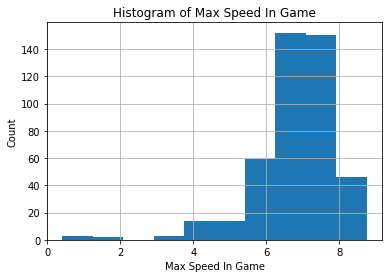

In [21]:
merged_df['MaxSpeedInGame'].hist()
plt.title('Histogram of Max Speed In Game')
plt.xlabel('Max Speed In Game')
plt.ylabel('Count')
plt.show()

There are some outliers in the form of very low speed individuals in our data set. Including these will harm the linear models we plan to use so we will exclude them. Ming had also stated that he does not believe any woman can run more than 9 m/s. We can try applying the IQR outlier removal rule and see if the upper bound is close to this.

In [22]:
q1 = merged_df['MaxSpeedInGame'].quantile(0.25)
q1

6.3722967645

In [23]:
q3 = merged_df['MaxSpeedInGame'].quantile(0.75)
q3

7.504635633333335

In [24]:
iqr = q3 - q1
iqr

1.132338868833335

In [25]:
merged_df.to_csv('./processed_data/merged_df.csv')

In [26]:
upper_bound = q3 + iqr*1.5
upper_bound

9.203143936583338

Using the IQR outlier removal rule, the upper bound is about 9 m/s which means this must be a good method for removing outliers

In [27]:
merged_df = merged_df[(merged_df['MaxSpeedInGame'] >= q1 - 1.5*iqr) & (merged_df['MaxSpeedInGame'] <= upper_bound)]

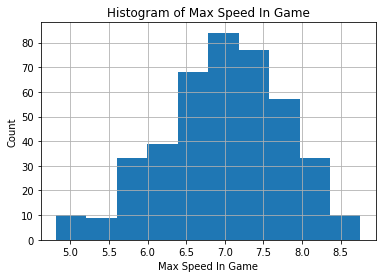

In [28]:
merged_df['MaxSpeedInGame'].hist()
plt.title('Histogram of Max Speed In Game')
plt.xlabel('Max Speed In Game')
plt.ylabel('Count')
plt.show()

After removing outliers our performance data is normally distributed and is better suited to being the response in a regression model.

## Correlations Between Predictors and Response

Based on our previous analysis, we think that `AcuteChronicRatio`, `MonitoringScore`, `Pain`, `Illness`, `Menstruation`, `Nutrition` will be predictors for `MaxSpeedInGame` which is our measure for performance. We also have an overall score for wellness called `wellness` which is the combination of all predictors other than `AcuteChronicRatio`.

In [29]:
def scatter_plot(df, x, y, title=None, hold_plot = False):
    plt.scatter(df[x], df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    
    if title:
        plt.title(title)
    
    if not hold_plot:
        plt.show()

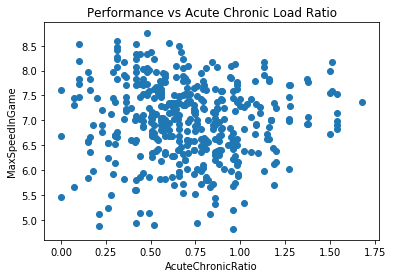

In [30]:
scatter_plot(merged_df, 'AcuteChronicRatio', 'MaxSpeedInGame', 'Performance vs Acute Chronic Load Ratio')


It does not look like there is any clear pattern between load and performance.

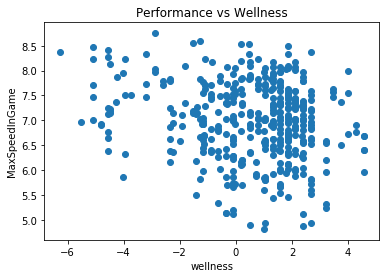

In [31]:
scatter_plot(merged_df, 'wellness', 'MaxSpeedInGame', 'Performance vs Wellness')


Similarly, we do not see any clear pattern between performance and wellness.

In [32]:
grouped_merged_df = merged_df[['wellness', 'MaxSpeedInGame', 'PlayerID']].groupby('PlayerID').mean()
grouped_merged_df

,wellness,MaxSpeedInGame
PlayerID,,
1,1.149699,7.683961
2,-0.450273,6.902797
3,1.940559,7.230131
4,0.956059,6.799333
5,-0.831605,7.721914
6,1.075347,6.511335
7,0.513464,7.309137
8,0.616924,7.159093
9,-0.551233,6.931128


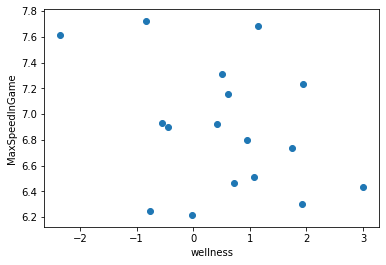

In [33]:
scatter_plot(grouped_merged_df, 'wellness', 'MaxSpeedInGame')

When we average the data by player, we do not see a clear pattern between wellness and performance.

We see that there are no clear patterns when we are looking at the repeated measures data. It is possible that using a regression model will illuminate some relationships in the data, particularly for individual features of wellness.

## Regressions Of Wellness and Load on Performance

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import aic
from statsmodels.graphics.gofplots import qqplot

### Mixed Linear Models

We want to first model the relationship between Load and Wellness vs performance using a mixed linear model. This is because our data includes repeated measurements for each player over many games. In this case, the random effect will be the player id such that we group the measurements by player. We will be using random intercepts but not random slopes. This means we allow each player to have a random intercept, or random base level of performance, but each player should share the same slopes for each predictor. In this way, we allow the model to adjust to the base performance level of each player but we find relationships between the predictors and the response that are generalizable across the entire team.

The relationship between acute chronic ratio and performance is known to be non-linear so we add a squared term to our regression equation.

In [35]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ AcuteChronicRatio + np.power(AcuteChronicRatio, 2) + MonitoringScore + SleepHours + Pain + Illness + Nutrition + Menstruation", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     MaxSpeedInGame
No. Observations:      420         Method:                 REML          
No. Groups:            17          Scale:                  0.4134        
Min. group size:       4           Likelihood:             -440.0633     
Max. group size:       38          Converged:              Yes           
Mean group size:       24.7                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       7.633    0.650 11.744 0.000  6.359  8.906
AcuteChronicRatio              -0.335    0.409 -0.817 0.414 -1.137  0.468
np.power(AcuteChronicRatio, 2)  0.140    0.253  0.551 0.581 -0.356  0.636
MonitoringScore                -0.015    0.010 -1.453 0.

In [36]:
aic1 = aic(mixed_res.llf, 415, 9)
aic1


898.1265549139007

We can use this AIC measure as a baseline for comparing this model to the models below. Given that p-values for mixed linear models are unreliable, we will use AIC as our metric for model selection. We want to remove uninformative features such that it makes the AIC of the model lower. In doing so, we hope to find a model that gives us some insights into the relationship between a subset of these predictors and the performance of players.

We see that even though we are modeling the realationship between load and perfromance non-linearly, we see that the 95% confidence interval for the load terms contains positive and negative values including 0. Furthermore, the standard error of the estimates for the coefficients are similar in magnitude to the estimates themselves, meaning the true value could be far from the estimate given. Thus, we cannot make any conclusions about relationship between performance and load given this model. This is not what we expected but makes sense based on our data as we found no clear patterns in the relationship between load and performance in the scatter plots above. Thus, we should remove the load terms from the model and see if we can find any stronger relationships for some of the wellness predictors.

We are tempted to expand the monitoring score into the predictors that make it up, but as we say in the wellness exploratory notebook, these predictors are all correlated with each other, so they cannot be predictors in a model.

Thus, we will remove the load values and see what the resulting model looks like.

#### Remove Training Load

In [37]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ MonitoringScore + SleepHours + Pain + Illness + Nutrition + Menstruation", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 420     Method:             REML          
No. Groups:       17      Scale:              0.4124        
Min. group size:  4       Likelihood:         -439.0420     
Max. group size:  38      Converged:          Yes           
Mean group size:  24.7                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          7.463    0.624 11.968 0.000  6.241  8.685
MonitoringScore   -0.015    0.010 -1.471 0.141 -0.035  0.005
SleepHours         0.010    0.039  0.248 0.804 -0.066  0.085
Pain              -0.187    0.115 -1.632 0.103 -0.412  0.038
Illness           -0.148    0.145 -1.026 0.305 -0.432  0.135
Nutrition          0.110    0.094  1.169 0.242 -0.075  0.296
Menstruation      -0.028    0.115 -0

In [38]:
aic2 = aic(mixed_res.llf, 415, 7)
aic2

892.0840687780228

In [39]:
np.exp((min([aic1, aic2]) - max([aic1, aic2])) / 2)

0.0487405928207259

The AIC for this model is less than that of the first model, suggesting that this model loses less information from the process that generated the data compared to the first model, which is to say it is a better model of the data. In fact, the first model is only about `0.049` times as likely to minimize the information lost as the second model. 

The standard error is much larger than the point estimate for Menstruation which is near 0. The model is very uncertain about the effect of Menstruation and thus, it should be removed.

#### Remove Menstruation

In [40]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ MonitoringScore + SleepHours + Pain + Illness + Nutrition ", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 420     Method:             REML          
No. Groups:       17      Scale:              0.4115        
Min. group size:  4       Likelihood:         -437.8254     
Max. group size:  38      Converged:          Yes           
Mean group size:  24.7                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          7.429    0.607 12.242 0.000  6.240  8.618
MonitoringScore   -0.015    0.010 -1.477 0.140 -0.035  0.005
SleepHours         0.010    0.038  0.271 0.786 -0.065  0.086
Pain              -0.188    0.114 -1.647 0.100 -0.412  0.036
Illness           -0.147    0.144 -1.020 0.308 -0.430  0.136
Nutrition          0.110    0.094  1.171 0.242 -0.074  0.295
Group Var          0.187    0.120   

In [41]:
aic3 = aic(mixed_res.llf, 415, 6)
aic3


887.6508568841068

In [42]:
np.exp((aic3 - aic2) / 2)

0.10897836017602136

We see that after removing Menstruation, we get another model with an even lower AIC. Compared to this new model, the second model is only about `0.109` times as likely to lose less information. Looking at the estimate for sleep hours, the standard error is much larger than the point estimate which means the model is very uncertain about the effect of sleep hours. Thus, it should be removed.

#### Remove Sleep Hours

In [43]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ MonitoringScore + C(Pain) + Illness + Nutrition", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 420     Method:             REML          
No. Groups:       17      Scale:              0.4105        
Min. group size:  4       Likelihood:         -435.5227     
Max. group size:  38      Converged:          Yes           
Mean group size:  24.7                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          7.508    0.531 14.153 0.000  6.469  8.548
C(Pain)[T.1.0]    -0.191    0.114 -1.684 0.092 -0.414  0.031
MonitoringScore   -0.014    0.010 -1.465 0.143 -0.033  0.005
Illness           -0.149    0.144 -1.034 0.301 -0.431  0.133
Nutrition          0.110    0.094  1.165 0.244 -0.075  0.294
Group Var          0.187    0.120                           



In [44]:
aic4 = aic(mixed_res.llf, 415, 5)
aic4

881.0453048765698

In [45]:
np.exp((aic4 - aic3) / 2)

0.03678092157260381

Removing sleep hours lowers our model's AIC yet again. Specifically, the third model is only `0.037` times as probable to minimize the information loss compared to the 4th model. Looking at the coefficient estimate for the monitoring score, we see that its point estimate is close to 0 and it's standard error is small, which means it is likely to be 0 or that the effect size of the relationship to performance  is very small. Thus, we could remove monitoring score from the model.

#### Remove Monitoring Score

In [46]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ C(Pain) + Illness + Nutrition", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 420     Method:             REML          
No. Groups:       17      Scale:              0.4114        
Min. group size:  4       Likelihood:         -432.8815     
Max. group size:  38      Converged:          Yes           
Mean group size:  24.7                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          7.270    0.506 14.377 0.000  6.279  8.261
C(Pain)[T.1.0]    -0.216    0.113 -1.922 0.055 -0.437  0.004
Illness           -0.140    0.144 -0.972 0.331 -0.422  0.142
Nutrition          0.094    0.094  0.999 0.318 -0.090  0.278
Group Var          0.191    0.122                           



In [47]:
aic5 = aic(mixed_res.llf, 415, 4)
aic5

873.7630632031078

In [48]:
np.exp((aic5 - aic4) / 2)

0.026222935858217732

We see that after removing the monitoring score, our model's AIC drops slightly. In fact, the previous model with the monitoring score is `0.026` times as likely to minimize the information loss compared to this model. Thus, we can conclude this new model is the best fit to the data we have trained so far.

The point estimate for illness is about the same magnitude as the standard error so we cannot make any conclusions about its effect. It is entirely possible that this coefficient is actually 0 instead of negative. Thus, we could improve the model by removing it.

#### Remove Illness

In [49]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ C(Pain) + Nutrition", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 420     Method:             REML          
No. Groups:       17      Scale:              0.4107        
Min. group size:  4       Likelihood:         -432.3287     
Max. group size:  38      Converged:          Yes           
Mean group size:  24.7                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          6.859    0.279 24.610 0.000  6.313  7.405
C(Pain)[T.1.0]    -0.220    0.113 -1.951 0.051 -0.440  0.001
Nutrition          0.094    0.094  1.006 0.314 -0.090  0.279
Group Var          0.200    0.126                           



In [50]:
aic6 = aic(mixed_res.llf, 415, 3)
aic6

870.6574434269673

In [51]:
np.exp((aic6 - aic5) / 2)

0.211652417891768

We see that removing illness from the model improves the AIC value. However, the improvement is the smallest yet as the 4th model is about `0.212` times as likely to actually minimize the information lost as the 5th model. We also see that the standard error is equal to the point estimate for Nutrition so we cannot be sure of its true effect on the response. The coefficient could actually be 0 so we should remove it.

#### Remove Nutrition

In [88]:
mixed_mod = smf.mixedlm("MaxSpeedInGame ~ C(Pain)", merged_df, groups=merged_df['PlayerID'])
mixed_res = mixed_mod.fit()
print(mixed_res.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 420     Method:             REML          
No. Groups:       17      Scale:              0.4103        
Min. group size:  4       Likelihood:         -431.3861     
Max. group size:  38      Converged:          Yes           
Mean group size:  24.7                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          7.094    0.153 46.299 0.000  6.794  7.394
C(Pain)[T.1.0]    -0.202    0.111 -1.817 0.069 -0.420  0.016
Group Var          0.205    0.129                           



In [89]:
aic7 = aic(mixed_res.llf, 415, 2)
aic7

866.7721256629279

In [90]:
np.exp((aic7 - aic6) / 2)

0.14332236544813928

We see that the model is improved by removing nutrition. This leaves us with a model containing one predictor: Pain. The standard error of the pain coefficient is small compared to its point estimate so we can be confident that the direction of the effect and that the point estimate itself is relatively accurate.

We might wonder if we can use regression to try and find a trend in the general association between wellness and perforamance:

In [91]:
mixed_mod_alt = smf.mixedlm("MaxSpeedInGame ~ wellness", merged_df, groups=merged_df['PlayerID'])
mixed_res_alt = mixed_mod_alt.fit()
print(mixed_res_alt.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 420     Method:             REML          
No. Groups:       17      Scale:              0.4101        
Min. group size:  4       Likelihood:         -433.1693     
Max. group size:  38      Converged:          Yes           
Mean group size:  24.7                                      
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      6.932     0.118  58.973  0.000   6.701   7.162
wellness      -0.034     0.019  -1.820  0.069  -0.070   0.003
Group Var      0.209     0.131                               



In [92]:
aic8 = aic(mixed_res_alt.llf, 415, 2)
aic8

870.3386768068845

In [93]:
np.exp((aic7 - aic8) / 2)

0.16808666458264068

We see that the model with wellness in general as the predictor is only `0.168` times as probable as minimizing the information lost compared to the process that generated the data. In addition to the, the magnitude of the coefficient is small so any effect that wellness has on performance is minuscule if it exists at all.

It seems our model with pain as the only predictor is a good fit to the data. To verify this, we can fit another kind of model that accepted repreated measures called a generalized estimating equation (GEE) model. GEE models require that we provide the structure of the covariance between groups. We will use the Exchangeable covariance structure which assumes the measurements in a given group are correlated in the same way. In our case, that is to say the measurements for each player are correlated in the same way which makes sense. In fact, GEE with exchangeable correlation structure is annalogus to a mixed model with random intercepts, however, GEE uses a different algorithm to estimate the value of the parameters. For example, in [this article](https://healthsci.mcmaster.ca/docs/librariesprovider8/research/methodology/study-design-and-methodological-issues/statistical-analysis-of-correlated-data-using-generalized-estimating-equations--an-orientation.pdf?sfvrsn=4b1c0d3b_4), Hanley et. al. describe how GEE uses a quasi-liklihood approach and uses weighted combinations of observations to extract the appropriate amount of information from correlated data. If we get similar conclusions from this alternative measure of analysing correlated data, it will add more support to our conclusions. Some research indicates that GEE is actually better than mixed models, for example, in [this paper](https://www.ncbi.nlm.nih.gov/pubmed/20220526), Hubbard et. al. argue that: "in general that mixed models involve unverifiable assumptions on the data-generating distribution, which lead to potentially misleading estimates and biased inference. We conclude that the estimation-equation approach of population average models provides a more useful approximation of the truth."

Thus, if we find that the GEE model has similar coefficient estimates to the mixed model, this adds evidence that those coefficients are representative of the actual relationships in the data.

In [79]:
fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()
mod = smf.gee("MaxSpeedInGame ~ C(Pain)", "PlayerID", merged_df, cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())

                               GEE Regression Results                              
Dep. Variable:              MaxSpeedInGame   No. Observations:                  420
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                  38
Family:                           Gaussian   Mean cluster size:                24.7
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Tue, 10 Dec 2019   Scale:                           0.590
Covariance type:                    robust   Time:                         16:53:06
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.1098      0.156     45.613      0.000       6.804       7

We see that the coefficients of the GEE model are in fact similar to those of the mixed model.

#### Test Model Fit

Before interpreting the coefficients, we should check our assumption that the model is a good fit to the data. We can do this by first doing a QQ plot to ensure that the residuals of the model are uniformly distributed.

##### QQ Plot for Mixed Model

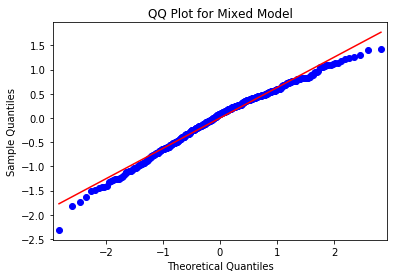

In [53]:
qqplot(mixed_res.resid, line='s')
plt.title('QQ Plot for Mixed Model')
plt.show()

##### QQ Plot for GEE Model

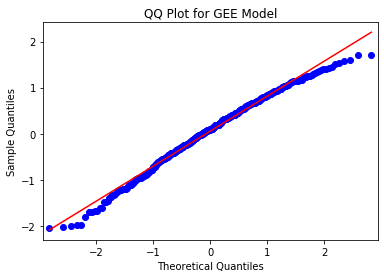

In [54]:
qqplot(res.resid, line='s')
plt.title('QQ Plot for GEE Model')
plt.show()

We see that, for the most part, the QQ plot is a straight line which means the residuals are normally distributed. For both models, there are slight deviations from the line for large positive residuals, wherein the mixed model is closer to normally distributed than the GEE model. However, this deviation is minute and both models have similar coefficients so we conclude that they are both good fits to the data and we can interpret the coefficients of either model to infer the relationship between the predictor and the response.

##### Mixed Model Standardized Residuals

We can also plot the standardized residuals versus the predictors to ensure that there are no patterns in the residuals with respect to any of the predictors.

In [94]:
def plot_residuals_for_model(m):

    residuals = merged_df[['Pain']]
    residuals['Residual'] = (m.resid - m.resid.mean()) / m.resid.std()

    #plt.subplot(1, 2, 1)
    scatter_plot(residuals, 'Pain', 'Residual', 'Residuals vs Pain', hold_plot=True)
    #plt.subplot(1, 2, 2)
    #scatter_plot(residuals, 'Nutrition', 'Residual', 'Residuals vs Nutrition', hold_plot=True)
    #plt.tight_layout()
    plt.show()


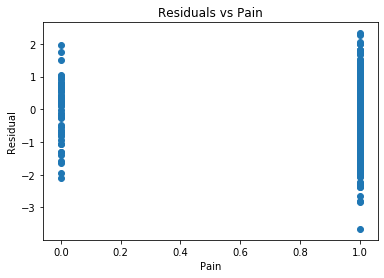

In [95]:
plot_residuals_for_model(mixed_res)


##### GEE Standardized Residuals

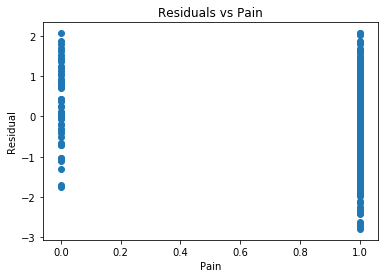

In [96]:
plot_residuals_for_model(res)


We see that there is no pattern in the residuals for either predictor which, taken with the QQ plots is solid evidence that both models are good fits to the data. We can see from the residual plot for Pain that there are more samples in the training set with pain set to 1 over 0. This means more players played without pain than played with pain. This imbalance could explain the unexpected result we got in the model (that not being in pain leads to worse performance). This will be further explored in the coefficient interpretation section below.

### Coefficient Interpretation

Before interpreting the coefficients, we should review the variability of the performance data so we can contextualize the effect sizes of the relationships between the effects and the responses.

In [98]:
merged_df['MaxSpeedInGame'].std()

0.7763611995236209

We see that the standard deviation of the performance metric is about `0.78`.

#### Pain

Looking at the coefficients of our model above, we see moderately strong evidence that Pain has a negative relationship to performance. The standard error of this estimate is about half of the point estimate itself. Recalling how we coded pain, this is interesting because pain equal to 1 refers to not being in pain. Thus, better wellness with respect to pain is leading to worse performance.

In [99]:
def find_games_played_in_pain(row):
    games = merged_df[merged_df['PlayerID'] == row['PlayerID']]
    return len(games[games['Pain'] == 0])

averaged_df = merged_df.copy()[['PlayerID', 'MaxSpeedInGame', 'Pain']].groupby('PlayerID').mean().reset_index()
averaged_df.columns = ['PlayerID', 'AverageMaxSpeedInGame', 'ProbabilityOfPlayingNotInPain']
averaged_df['GamesPlayedInPain'] =  averaged_df.apply(find_games_played_in_pain, axis=1)
averaged_df

,PlayerID,AverageMaxSpeedInGame,ProbabilityOfPlayingNotInPain,GamesPlayedInPain
0,1,7.683961,0.964286,1
1,2,6.902797,0.685714,11
2,3,7.230131,1.000000,0
3,4,6.799333,1.000000,0
4,5,7.721914,0.714286,8
5,6,6.511335,1.000000,0
6,7,7.309137,0.818182,6
7,8,7.159093,0.818182,6
8,9,6.931128,1.000000,0
9,10,7.614805,0.384615,16


We see that the games played in pain come from a subset of players (2, 5, 7, 8, and 10). These players tended to play a substantial amount of their games in pain and they also tend to be higher performing players on average. In the extreme case, player 10 played most of their games in pain, yet they are one of the fastest players on the team.

There are many possible reasons for this imbalance. Some players might have different definitions of pain. For example, player 10 might have a more liberal view of pain and marks themselves as in pain often while a player like player 12, who was never in pain while playing, might have a very strict view of pain and must be very hurt to mark themselves as in pain. Alternatively, some players might not be as affected by being in pain and encouraged to play while in pain, while other players who are affected by being in pain are not played while they are hurt.

This example highlights the selection bias in our dataset. There were some choices that went into which players played a given game so we cannot see the true effect of load and wellness on performance. In other words, we might not see performance issues due to poor wellness because we do not have performance data for instances where wellness was low, since a player with low wellness might not be played. Had we done a controlled experiment where we very different factors of load and wellness and measure subsequent performance, we might be able to find stronger relationships between load, wellness, and performance. Given that many factor of wellness cannot be controlled for an experiment, we could also use data from more controlled performance testing that is completed regardless of the wellness of players so we could see the effect of all different values of wellness on performance.

Thus, our coefficient for pain is misleading as the pain data in imbalanced because the inevitable instances of poor performance while in pain are missing from the dataset.

### Conclusions

The player's max speed in a game has a lot of variance in it and it is hard to model the relationship between wellness, load, and performance using the data we have. Furthermore, the selection bias present in the data we have on performance makes it hard to draw useful conclusions from our analysis.

## Effect of Wellness On RPE

Now that we have explored the relationships between load and wellness on performance, we want to explore the relationship between wellness and load independent of performance. We will continue to use the same wellness predictors as before, however, for load we will use RPE as the target. This is because we want to see how wellness affected the perceived intensity of workouts.

In [63]:
raw_rpe['Date'] = pd.to_datetime(raw_rpe['Date'])
rpe_wellness = wellness_df.merge(raw_rpe, on=['Date', 'PlayerID'])
rpe_wellness = rpe_wellness.dropna()
rpe_wellness.head()

,Date,PlayerID,MonitoringScore,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Menstruation,...,TrainingReadiness,StandardizedMonitoringScore,StandardizedPain,StandardizedIllness,StandardizedNutrition,StandardizedMenstruation,StandardizedTrainingReadiness,wellness,WellnessAffectedByLoad,RPE
0,2017-11-30,1,16.0,2.0,3.0,2.0,3.0,9.00,6.0,1.0,...,80.0,-0.639228,0.363863,0.330081,0.716267,0.716267,0.407056,0.770983,1.178039,7.0
1,2017-11-30,1,16.0,2.0,3.0,2.0,3.0,9.00,6.0,1.0,...,80.0,-0.639228,0.363863,0.330081,0.716267,0.716267,0.407056,0.770983,1.178039,2.0
2,2017-11-30,1,16.0,2.0,3.0,2.0,3.0,9.00,6.0,1.0,...,80.0,-0.639228,0.363863,0.330081,0.716267,0.716267,0.407056,0.770983,1.178039,4.0
3,2017-11-30,2,22.0,4.0,4.0,5.0,4.0,8.75,5.0,1.0,...,0.0,0.980185,0.363863,0.330081,0.716267,0.716267,0.407056,2.390396,2.797452,1.0
4,2017-11-30,2,22.0,4.0,4.0,5.0,4.0,8.75,5.0,1.0,...,0.0,0.980185,0.363863,0.330081,0.716267,0.716267,0.407056,2.390396,2.797452,6.0


### Exploratory Analysis

Before we get into modeling, we should look at the distribution of the response and see if there are any outliers that would affect our model.

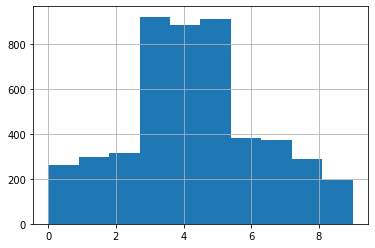

In [64]:
rpe_wellness['RPE'].hist()

### Regression Models

In [65]:
rpe_wellness = rpe_wellness.dropna()
mixed_rpe_mod = smf.mixedlm("RPE ~ wellness", rpe_wellness, groups=rpe_wellness['PlayerID'])
mixed_rpe_res = mixed_rpe_mod.fit()
print(mixed_rpe_res.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: RPE        
No. Observations: 4822    Method:             REML       
No. Groups:       17      Scale:              4.7003     
Min. group size:  151     Likelihood:         -10599.7985
Max. group size:  452     Converged:          Yes        
Mean group size:  283.6                                  
----------------------------------------------------------
            Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept   4.292     0.125  34.431  0.000   4.048   4.537
wellness    0.031     0.018   1.731  0.083  -0.004   0.065
Group Var   0.246     0.043                               



In [66]:
fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()

rpe_wellness_gee = smf.gee("RPE ~ wellness", "PlayerID", rpe_wellness, cov_struct=ind, family=fam)
rpe_wellness_gee_fit = rpe_wellness_gee.fit()
print(rpe_wellness_gee_fit.summary())


                               GEE Regression Results                              
Dep. Variable:                         RPE   No. Observations:                 4822
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                 151
                      Estimating Equations   Max. cluster size:                 452
Family:                           Gaussian   Mean cluster size:               283.6
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Tue, 10 Dec 2019   Scale:                           4.939
Covariance type:                    robust   Time:                         16:44:40
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2923      0.121     35.350      0.000       4.054       4.530
wellnes

We see that the mixed and GEE models above both suggest a small positive relationship between RPE and wellness. If we expand wellness out into the elements that form it, we could find which specific aspects of wellness have a relationship with RPE.

First, let's fit a mixed linear model using the elements of our wellness score as predictors.

In [67]:
mixed_rpe_mod = smf.mixedlm("RPE ~ MonitoringScore + TrainingReadiness + Pain + Illness + Nutrition", rpe_wellness, groups=rpe_wellness['PlayerID'])
mixed_rpe_res = mixed_rpe_mod.fit()
print(mixed_rpe_res.summary())


           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  RPE        
No. Observations:  4822     Method:              REML       
No. Groups:        17       Scale:               4.6853     
Min. group size:   151      Likelihood:          -10598.9753
Max. group size:   452      Converged:           Yes        
Mean group size:   283.6                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          3.531    0.375  9.419 0.000  2.796  4.266
MonitoringScore   -0.012    0.011 -1.026 0.305 -0.034  0.011
TrainingReadiness  0.005    0.002  3.001 0.003  0.002  0.008
Pain               0.261    0.120  2.169 0.030  0.025  0.497
Illness           -0.098    0.078 -1.248 0.212 -0.251  0.056
Nutrition          0.246    0.079  3.102 0.002  0.090  0.401
Group Var          0.198    0.035   

In [68]:
rpe_aic1 = aic(mixed_rpe_res.llf, 4822, 6)
rpe_aic1

21209.950655156383

We see that the AIC is much larger than our previous model of performance. Modeling RPE in this was is losing a lot of information but we can still use regression to explore the relationship between RPE and the elements of wellness even if this model will not have a lot of predictive power.

Looking at the coefficients of the model above, we see that the standard error of the monitoring score estimate is equally as large in magnitiude as the point estimate itself. It very well could be the case that this coefficient should actually be 0 or positive so we can try removing it from our model as the data cannot tell us anything conclsive about the relationship between the monitoring score and RPE.

In [69]:
mixed_rpe_mod = smf.mixedlm("RPE ~ TrainingReadiness + Pain + Illness + Nutrition", rpe_wellness, groups=rpe_wellness['PlayerID'])
mixed_rpe_res = mixed_rpe_mod.fit()
print(mixed_rpe_res.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  RPE        
No. Observations:  4822     Method:              REML       
No. Groups:        17       Scale:               4.6852     
Min. group size:   151      Likelihood:          -10595.9467
Max. group size:   452      Converged:           Yes        
Mean group size:   283.6                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          3.375    0.343  9.836 0.000  2.703  4.048
TrainingReadiness  0.005    0.002  2.843 0.004  0.001  0.008
Pain               0.250    0.120  2.083 0.037  0.015  0.484
Illness           -0.106    0.078 -1.353 0.176 -0.258  0.047
Nutrition          0.247    0.079  3.123 0.002  0.092  0.402
Group Var          0.200    0.036                           



In [70]:
rpe_aic2 = aic(mixed_rpe_res.llf, 4822, 5)
rpe_aic2

21201.89338955828

In [71]:
np.exp((rpe_aic2 - rpe_aic1)/2)

0.017798647654249256

Our model with monitoring score removed loses much less data, with the first model only about 0.016 times as likely as the second model to minimize the information loss. Thus, we can confidently say the second model is better than the first.

Looking at the coefficient for illness, the standard error is close to the point estimate so we might be tempted to remove this predictor as the true value of the predictor may be closer to 0 or might even be positive.

In [72]:
mixed_rpe_mod = smf.mixedlm("RPE ~ TrainingReadiness + Pain + Nutrition", rpe_wellness, groups=rpe_wellness['PlayerID'])
mixed_rpe_res = mixed_rpe_mod.fit()
print(mixed_rpe_res.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: RPE        
No. Observations:   4822    Method:             REML       
No. Groups:         17      Scale:              4.6860     
Min. group size:    151     Likelihood:         -10595.2298
Max. group size:    452     Converged:          Yes        
Mean group size:    283.6                                  
-----------------------------------------------------------
                  Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         3.102    0.277 11.187 0.000  2.558  3.645
TrainingReadiness 0.004    0.002  2.718 0.007  0.001  0.007
Pain              0.247    0.120  2.062 0.039  0.012  0.482
Nutrition         0.244    0.079  3.087 0.002  0.089  0.399
Group Var         0.200    0.036                           



In [73]:
rpe_aic3 = aic(mixed_rpe_res.llf, 4822, 5)
rpe_aic3

21200.459651031204

In [74]:
np.exp((rpe_aic3 - rpe_aic2)/2)

0.4882785369404368

The model without illness is not that much better than the model that includes illness. In fact, the model that includes illness is about 0.48 times as likily as the model without illness to minimize information loss. Thus, we don't have enought evidence to discount the model with illness and we need to value its coefficient estimates as well.

As with previous regressions, we will train a GEE model as well to see if we get similar coefficients. Note that we will include illness as a predictor because removing it did not result in a much better mixed linear model so there is evidence that it is a valuable predictor.

In [75]:
rpe_wellness_gee = smf.gee("RPE ~ TrainingReadiness + Pain + Illness + Nutrition", "PlayerID", rpe_wellness, cov_struct=ind, family=fam)
rpe_wellness_gee_fit = rpe_wellness_gee.fit()
print(rpe_wellness_gee_fit.summary())


                               GEE Regression Results                              
Dep. Variable:                         RPE   No. Observations:                 4822
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                 151
                      Estimating Equations   Max. cluster size:                 452
Family:                           Gaussian   Mean cluster size:               283.6
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Tue, 10 Dec 2019   Scale:                           4.884
Covariance type:                    robust   Time:                         16:44:40
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.3783      0.400      8.451      0.000       2.59

### Test Model Fit

We will test the model fit using residual plots and QQ plots as previously done in this notebook.

#### QQ Plots For Mixed Model

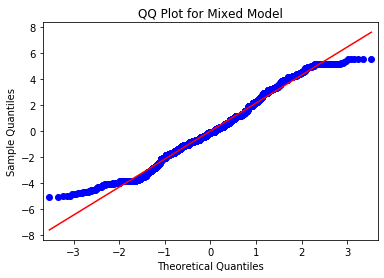

In [76]:
qqplot(mixed_rpe_res.resid, line='s')
plt.title('QQ Plot for Mixed Model')
plt.show()

#### QQ Plots for GEE Model

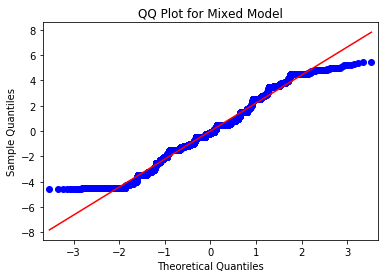

In [77]:
qqplot(rpe_wellness_gee_fit.resid, line='s')
plt.title('QQ Plot for Mixed Model')
plt.show()

We see from the QQ plots above that the residuals are not quite normally distributed, with the issue occuring at the extreme values of the residuals. This would be more of an issue if we were interested in predicting RPE but for our exploratory analysis, the slight non-normality of the residuals should not be too much of an issue.

In [78]:
pre_wellness_predictions = rpe_wellness_mixed_fit.predict()
residual_df = model_rpe_wellness.copy()[['MonitoringScore', 'TrainingReadiness', 'Illness', 'Pain', 'Nutrition', 'RPE']]
residual_df['Prediction'] = pre_wellness_predictions
residual_df['Residuals'] = residual_df['RPE'] - residual_df['Prediction']
residual_df.head()


NameError: name 'rpe_wellness_mixed_fit' is not defined

In [ ]:
scatter_plot(residual_df, 'MonitoringScore', 'Residuals', 'Residuals VS Monitoring Score')

## Performance vs Training load graphs per player

In [ ]:
grouped = merged_df.copy().groupby('PlayerID')

for name,group in grouped:
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(121)

    group.plot.bar(ax=ax1, color='red',x="GameID",y="MaxSpeedInGame")
    ax1.set_ylabel('MaxSpeedInGame')
    ax3 = ax1.twinx()
    group.plot.bar(ax=ax3, color='blue',x="GameID",y="AcuteChronicRatio",fill=False)

    ax1.set_title('Player ' + str(name), fontsize=15)
    ax2 = fig.add_subplot(122)
    group.plot.bar(ax=ax2, color='green',x="GameID",y="MaxAccelImpulseInGame")
    ax2.set_ylabel('MaxAccelImpulseInGame')
    ax4 = ax2.twinx()
    group.plot.bar(ax=ax4, color='blue',
                    x='GameID',
                    y="AcuteChronicRatio",fill=False)

    ax2.set_title('Player ' + str(name), fontsize=15)

plt.show()
plt.close()

## Performance vs Training load graphs for each game for all players

In [ ]:
grouped_by_game = merged_df.copy().groupby(['GameID','Outcome','TeamPoints'])

for name,group in grouped_by_game:
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(121)

    group.plot.bar(ax=ax1, color='blue',x="PlayerID",y="MaxSpeedInGame")
    ax1.set_ylabel('MaxSpeedInGame')
    ax1.set_title('Game ' + str(name[0])+ 
                  ' Outcome: ' + str(name[1]) + 
                  ' Points: ' + str(name[2]), fontsize=15)
    ax3 = ax1.twinx()
    group.plot.bar(ax=ax3, color='red',
                    x='PlayerID',
                    y="AcuteLoad",fill=False)
    ax2 = fig.add_subplot(122)
    group.plot.bar(ax=ax2, color='green',x="PlayerID",y="MaxAccelImpulseInGame")
    ax2.set_ylabel('MaxAccelImpulseInGame')
    ax2.set_title('Game ' + str(name[0])+ 
                  ' Outcome: ' + str(name[1]) + 
                  ' Points: ' + str(name[2]), fontsize=15)
    ax4 = ax2.twinx()
    group.plot.bar(ax=ax4, color='red',
                    x='PlayerID',
                    y="AcuteLoad",fill=False)

plt.show()
plt.close()

## Performance vs wellness graphs per player

In [ ]:
grouped = merged_df.copy().groupby('PlayerID')

for name,group in grouped:
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(121)

    group.plot.bar(ax=ax1, color='red',x="GameID",y="MaxSpeedInGame")
    ax1.set_ylabel('MaxSpeedInGame')
    ax3 = ax1.twinx()
    group.plot.bar(ax=ax3, color='blue',x="GameID",y="wellness",fill=False)
    ax3.set_ylabel('wellness')
    ax1.set_title('Player ' + str(name), fontsize=15)



plt.show()
plt.close()

## Performance vs wellness and nutrition load graphs for each game for all players

In [ ]:
grouped_by_game = merged_df.copy().groupby(['GameID','Outcome','TeamPoints'])

for name,group in grouped_by_game:
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(121)

    group.plot.bar(ax=ax1, color='blue',x="PlayerID",y="MaxSpeedInGame")
    ax1.set_ylabel('MaxSpeedInGame')
    ax1.set_title('Game ' + str(name[0])+ 
                  ' Outcome: ' + str(name[1]) + 
                  ' Points: ' + str(name[2]), fontsize=15)
    ax3 = ax1.twinx()
    group.plot.bar(ax=ax3, color='red',
                    x='PlayerID',
                    y="wellness",fill=False)
    ax2 = fig.add_subplot(122)
    group.plot.bar(ax=ax2, color='green',x="PlayerID",y="MaxSpeedInGame")
    ax2.set_ylabel('MaxSpeedInGame')
    ax2.set_title('Game ' + str(name[0])+ 
                  ' Outcome: ' + str(name[1]) + 
                  ' Points: ' + str(name[2]), fontsize=15)
    ax4 = ax2.twinx()
    group.plot.bar(ax=ax4, color='red',
                    x='PlayerID',
                    y="Nutrition",fill=False)

plt.show()
plt.close()

Unfortunately there is no special relationship between the clusters for prformance, training and wellness.

## Conslusions

Mention final conclusions for the coach based on this data.